In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import ntpath

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz

import dhedfreader

%matplotlib inline 

In [2]:
# # The eeg data contains four event markers. We'll use these to explore the data.
# event_id = dict(response=4096, target=8192, NonTarget_High=16384, NonTarget_Low=32768)

# # This will determine the time window for the data that we care about
# tmin, tmax = -0.1, 1.

# path to data (change this to whereever you saved your data)
myPath = r'edf'

# Loading EDF data

In [3]:
# single subject
data = os.listdir(myPath)
dataPath = os.path.join(myPath, data[0])

# We use mne.read_raw_edf to read in the .bdf EEG files
raw = read_raw_edf(dataPath, preload=True, stim_channel=None, verbose=False)
raw

<RawEDF  |  SC4001E0-PSG.edf, n_channels x n_times : 7 x 7950000 (79500.0 sec), ~424.6 MB, data loaded>

# Explore EEG data

In [4]:
# what does our data look like?

print('Data type: {}\n\n{}\n'.format(type(raw), raw))
# print('{} \n'.format(raw))

# Get the sample rate
print('Sample rate:', raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(raw.get_data().shape))

# We can use the mne.info class to learn moure about the data.
print(raw.info)

Data type: <class 'mne.io.edf.edf.RawEDF'>

<RawEDF  |  SC4001E0-PSG.edf, n_channels x n_times : 7 x 7950000 (79500.0 sec), ~424.6 MB, data loaded>

Sample rate: 100.0 Hz
Size of the matrix: (7, 7950000)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG submental, Temp rectal, Event marker
    chs : list | 7 items (EEG: 7)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 50.0 Hz
    meas_date : tuple | 1989-04-24 16:13:00 GMT
    nchan : int | 7
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    ex

In [5]:
print('The actual data is just a matrix array!\n\n {}\n'.format(raw.get_data()))

The actual data is just a matrix array!

 [[ 5.01684982e-06 -2.57875458e-06  1.35970696e-06 ...  5.29816850e-06
  -4.64175824e-06  6.61098901e-06]
 [-2.46739927e-06  1.46739927e-06 -4.09890110e-06 ... -3.04322344e-06
  -3.71501832e-06  1.75531136e-06]
 [ 1.65086691e-05  1.60158730e-05  9.60952381e-06 ...  6.97306471e-05
   8.05721612e-05  1.02255189e-04]
 ...
 [ 3.55200000e-06  3.55356030e-06  3.55509506e-06 ...  3.46427255e-06
   3.46481729e-06  3.46539330e-06]
 [ 3.72064516e+01  3.72061537e+01  3.72058645e+01 ...  3.74298268e+01
   3.74295681e+01  3.74293032e+01]
 [ 9.20000000e+02  9.19251369e+02  9.18501596e+02 ...  8.83717035e+02
   8.83478461e+02  8.83239431e+02]]



In [6]:
raw.get_data().shape

(7, 7950000)

In [32]:
# sampling frequency
sampling_rate = raw.info['sfreq']
sampling_rate

100.0

In [8]:
raw.ch_names[0]

'EEG Fpz-Cz'

# visualizing the data

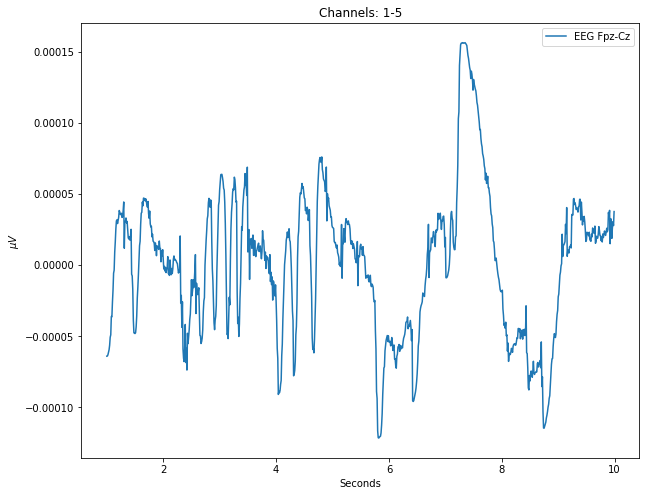

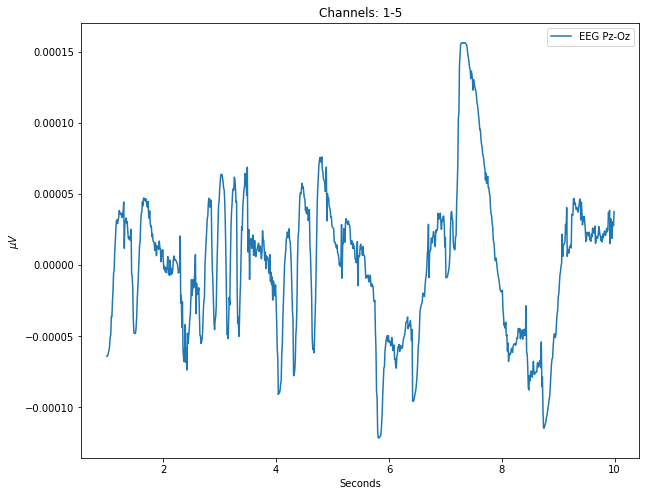

In [9]:
# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']

select_ch = "EEG Fpz-Cz"
# raw[Channel_ID, range (int(sfreq * 1):int(sfreq * 10))]

data_0, times_0 = raw[0, int(sfreq * 1):int(sfreq * 10)]
data_1, times_1 = raw[1, int(sfreq * 1):int(sfreq * 10)]

for i in range(2):
    fig = plt.subplots(figsize=(10,8))
    plt.plot(times_0, data_0.T);
    plt.xlabel('Seconds')
    plt.ylabel('$\mu V$')
    plt.title('Channels: 1-5');
    plt.legend(raw.ch_names[i:]);

<ipython-input-10-40d5f17e3b34>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmax=np.inf, fmax=250)


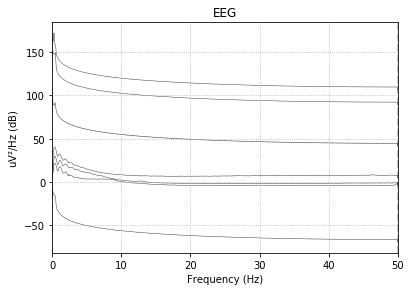

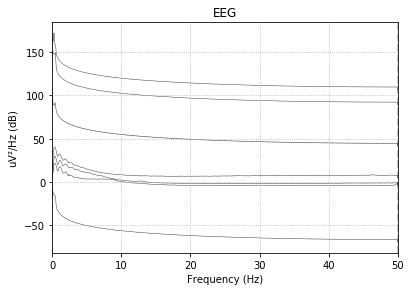

In [10]:
# power specturm
raw.plot_psd(tmax=np.inf, fmax=250)

In [11]:
#convert data matrix to a Pandas DataFrame to make it easier to work with 
raw_df = raw.to_data_frame()
raw_df.head()

Converting "time" to "<class 'numpy.int64'>"...


channel,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,Resp oro-nasal,EMG submental,Temp rectal,Event marker
time,,,,,,,
0,5.016850,-2.467399,16.508669,-4.820000e+08,3.552000,3.720645e+07,9.200000e+08
10,-2.578755,1.467399,16.015873,-4.775133e+08,3.553560,3.720615e+07,9.192514e+08
20,1.359707,-4.098901,9.609524,-4.727921e+08,3.555095,3.720586e+07,9.185016e+08
30,-2.391209,-2.659341,1.724786,-4.678363e+08,3.556603,3.720558e+07,9.177513e+08
40,-5.204396,-0.739927,7.638339,-4.626458e+08,3.558083,3.720531e+07,9.170012e+08


In [12]:
raw_ch_df = raw.to_data_frame(scaling_time=100.0)[select_ch]
raw_ch_df = raw_ch_df.to_frame()
raw_ch_df.set_index(np.arange(len(raw_ch_df)))

Converting "time" to "<class 'numpy.int64'>"...


,EEG Fpz-Cz
0,5.016850
1,-2.578755
2,1.359707
3,-2.391209
4,-5.204396
5,-7.454945
6,-8.298901
7,-6.892308
8,-3.704029
9,-0.984615


In [30]:
# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

stage_dict = {
    "W": W,
    "N1": N1,
    "N2": N2,
    "N3": N3,
    "REM": REM,
    "UNKNOWN": UNKNOWN
}

class_dict = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM",
    5: "UNKNOWN"
}

ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}

EPOCH_SEC_SIZE = 30

In [13]:
# Get raw header
f = open("edf/SC4001E0-PSG.edf", 'r', errors='ignore')
reader_raw = dhedfreader.BaseEDFReader(f)
reader_raw.read_header()
h_raw = reader_raw.header
f.close()
raw_start_dt = datetime.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")

In [14]:
# Read annotation and its header
f = open("edf/SC4001EC-Hypnogram.edf", 'r', errors='ignore')
reader_ann = dhedfreader.BaseEDFReader(f)
reader_ann.read_header()
h_ann = reader_ann.header
_, _, ann = zip(*reader_ann.records())
f.close()
ann_start_dt = datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

In [15]:
# Assert that raw and annotation files start at the same time
assert raw_start_dt == ann_start_dt

In [33]:
# Generate label and remove indices
remove_idx = []    # indicies of the data that will be removed
labels = []        # indicies of the data that have labels
label_idx = []
for a in ann[0]:
    onset_sec, duration_sec, ann_char = a
    #ann_str = "".join(ann_char)
    ann_str = ann_char[0][2:-1]
    label = ann2label[ann_str]
    if label != UNKNOWN:
        if duration_sec % EPOCH_SEC_SIZE != 0:
            raise Exception("Something wrong")
        duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
        label_epoch = np.ones(duration_epoch, dtype=np.int) * label
        labels.append(label_epoch)
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        label_idx.append(idx)

        print ("Include onset:{}, duration:{}, label:{} ({})".format(
            onset_sec, duration_sec, label, ann_str
        ))
    else:
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        remove_idx.append(idx)

        print ("Remove onset:{}, duration:{}, label:{} ({})".format(
            onset_sec, duration_sec, label, ann_str))
labels = np.hstack(labels)

Include onset:0.0, duration:30630.0, label:0 (Sleep stage W)
Include onset:30630.0, duration:120.0, label:1 (Sleep stage 1)
Include onset:30750.0, duration:390.0, label:2 (Sleep stage 2)
Include onset:31140.0, duration:30.0, label:3 (Sleep stage 3)
Include onset:31170.0, duration:30.0, label:2 (Sleep stage 2)
Include onset:31200.0, duration:150.0, label:3 (Sleep stage 3)
Include onset:31350.0, duration:30.0, label:3 (Sleep stage 4)
Include onset:31380.0, duration:60.0, label:3 (Sleep stage 3)
Include onset:31440.0, duration:60.0, label:3 (Sleep stage 4)
Include onset:31500.0, duration:30.0, label:3 (Sleep stage 3)
Include onset:31530.0, duration:120.0, label:3 (Sleep stage 4)
Include onset:31650.0, duration:30.0, label:3 (Sleep stage 3)
Include onset:31680.0, duration:120.0, label:3 (Sleep stage 4)
Include onset:31800.0, duration:30.0, label:0 (Sleep stage W)
Include onset:31830.0, duration:60.0, label:3 (Sleep stage 3)
Include onset:31890.0, duration:60.0, label:2 (Sleep stage 2)
Incl

In [34]:
print ("before remove unwanted: {}".format(np.arange(len(raw_ch_df)).shape))
if len(remove_idx) > 0:
    remove_idx = np.hstack(remove_idx)
    select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
else:
    select_idx = np.arange(len(raw_ch_df))
print ("after remove unwanted: {}".format(select_idx.shape))


before remove unwanted: (7950000,)
after remove unwanted: (7950000,)


In [35]:
# Select only the data with labels
print ("before intersect label: {}".format(select_idx.shape))
label_idx = np.hstack(label_idx)
select_idx = np.intersect1d(select_idx, label_idx)
print ("after intersect label: {}".format(select_idx.shape))

before intersect label: (7950000,)
after intersect label: (7950000,)


In [36]:
# Remove extra index
if len(label_idx) > len(select_idx):
    print("before remove extra labels: {}, {}".format(select_idx.shape, labels.shape))
    extra_idx = np.setdiff1d(label_idx, select_idx)
    # Trim the tail
    if np.all(extra_idx > select_idx[-1]):
        # n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
        # n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
        n_label_trims = int(math.ceil(len(extra_idx) / (EPOCH_SEC_SIZE * sampling_rate)))
        if n_label_trims!=0:
            # select_idx = select_idx[:-n_trims]
            labels = labels[:-n_label_trims]
    print("after remove extra labels: {}, {}".format(select_idx.shape, labels.shape))

# Remove movement and unknown stages if any
raw_ch = raw_ch_df.values[select_idx]

In [37]:
# Verify that we can split into 30-s epochs
if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
    raise Exception("Something wrong")
n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

# Get epochs and their corresponding labels
x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
y = labels.astype(np.int32)

assert len(x) == len(y)


In [38]:
# Select on sleep periods
w_edge_mins = 30
nw_idx = np.where(y != stage_dict["W"])[0]
start_idx = nw_idx[0] - (w_edge_mins * 2)
end_idx = nw_idx[-1] + (w_edge_mins * 2)
if start_idx < 0: start_idx = 0
if end_idx >= len(y): end_idx = len(y) - 1
select_idx = np.arange(start_idx, end_idx+1)
print("Data before selection: {}, {}".format(x.shape, y.shape))
x = x[select_idx]
y = y[select_idx]
print("Data after selection: {}, {}".format(x.shape, y.shape))


Data before selection: (2650, 3000, 1), (2650,)
Data after selection: (841, 3000, 1), (841,)


In [41]:
# Save
filename = ntpath.basename("SC4001E0-PSG.edf").replace("-PSG.edf", ".npz")
save_dict = {
    "x": x, 
    "y": y, 
    "fs": sampling_rate,
    "ch_label": select_ch,
    "header_raw": h_raw,
    "header_annotation": h_ann,
}
np.savez(os.path.join("out", filename), **save_dict)

print ("\n=======================================\n")

In [43]:
h_raw

{'local_subject_id': 'X F X Female_33yr',
 'local_recording_id': 'Startdate 24-APR-1989 X X X',
 'date_time': '2089-04-24 16:13:00',
 'EDF+': False,
 'contiguous': True,
 'n_records': 2650,
 'record_length': 30.0,
 'n_channels': 7,
 'label': ['EEG Fpz-Cz',
  'EEG Pz-Oz',
  'EOG horizontal',
  'Resp oro-nasal',
  'EMG submental',
  'Temp rectal',
  'Event marker'],
 'transducer_type': ['Ag-AgCl electrodes',
  'Ag-AgCl electrodes',
  'Ag-AgCl electrodes',
  'Oral-nasal thermistors',
  'Ag-AgCl electrodes',
  'Rectal thermistor',
  'Marker button'],
 'units': ['uV', 'uV', 'uV', '', 'uV', 'DegC', ''],
 'physical_min': array([ -192.,  -197., -1009., -2048.,    -5.,    34., -2047.]),
 'physical_max': array([ 192.,  196., 1009., 2047.,    5.,   40., 2048.]),
 'digital_min': array([-2048., -2048., -2048., -2048., -2500., -2849., -2047.]),
 'digital_max': array([2047., 2047., 2047., 2047., 2500., 2731., 2048.]),
 'prefiltering': ['HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'HP:0.5Hz LP:100Hz 